In [15]:
import os
from glob import glob
from itertools import chain

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
DATA_DIR = "/Users/anshikalohan/Downloads/images"
CSV_PATH = os.path.join(DATA_DIR, "Data_Entry_2017_v2020.csv")

IMAGE_SIZE = 256
BATCH_SIZE = 32

In [17]:
df = pd.read_csv(CSV_PATH)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [18]:
image_files = glob(os.path.join(DATA_DIR, "*.png"))

print("Total images found:", len(image_files))

Total images found: 112120


In [19]:
data_image_paths = {
    os.path.basename(p): p for p in image_files
}

df["path"] = df["Image Index"].map(data_image_paths.get)

In [20]:
print("Valid paths ratio:", df["path"].notna().mean())
df[["Image Index", "path"]].head()

Valid paths ratio: 1.0


,Image Index,path
0,00000001_000.png,/Users/anshikalohan/Downloads/images/00000001_...
1,00000001_001.png,/Users/anshikalohan/Downloads/images/00000001_...
2,00000001_002.png,/Users/anshikalohan/Downloads/images/00000001_...
3,00000002_000.png,/Users/anshikalohan/Downloads/images/00000002_...
4,00000003_001.png,/Users/anshikalohan/Downloads/images/00000003_...


In [21]:
df["Finding Labels"] = df["Finding Labels"].replace("No Finding", "")

In [22]:
labels = np.unique(
    list(
        chain(*df["Finding Labels"].map(lambda x: x.split("|")).tolist())
    )
)

labels = [l for l in labels if len(l) > 0]
labels

[np.str_('Atelectasis'),
 np.str_('Cardiomegaly'),
 np.str_('Consolidation'),
 np.str_('Edema'),
 np.str_('Effusion'),
 np.str_('Emphysema'),
 np.str_('Fibrosis'),
 np.str_('Hernia'),
 np.str_('Infiltration'),
 np.str_('Mass'),
 np.str_('Nodule'),
 np.str_('Pleural_Thickening'),
 np.str_('Pneumonia'),
 np.str_('Pneumothorax')]

In [23]:
for label in labels:
    df[label] = df["Finding Labels"].map(
        lambda x: 1.0 if label in x else 0.0
    )

In [24]:
labels = [label for label in labels if df[label].sum() > 1000]
labels.append("No_Finding")

df["No_Finding"] = (df[labels[:-1]].sum(axis=1) == 0).astype(float)

label_cols = labels.copy()
label_cols

[np.str_('Atelectasis'),
 np.str_('Cardiomegaly'),
 np.str_('Consolidation'),
 np.str_('Edema'),
 np.str_('Effusion'),
 np.str_('Emphysema'),
 np.str_('Fibrosis'),
 np.str_('Infiltration'),
 np.str_('Mass'),
 np.str_('Nodule'),
 np.str_('Pleural_Thickening'),
 np.str_('Pneumonia'),
 np.str_('Pneumothorax'),
 'No_Finding']

In [25]:
df = df.dropna(subset=["path"]).reset_index(drop=True)
df.shape

(112120, 27)

In [26]:
train_df, valid_df = train_test_split(
    df,
    test_size=0.2,
    random_state=2018,
    stratify=df["Finding Labels"].map(lambda x: x[:4])
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape, valid_df.shape)

(89696, 27) (22424, 27)


In [27]:
print("path exists:", "path" in train_df.columns)
print("labels OK:", all(col in train_df.columns for col in label_cols))
print(train_df["path"].head())

path exists: True
labels OK: True
0    /Users/anshikalohan/Downloads/images/00006446_...
1    /Users/anshikalohan/Downloads/images/00019455_...
2    /Users/anshikalohan/Downloads/images/00003645_...
3    /Users/anshikalohan/Downloads/images/00023699_...
4    /Users/anshikalohan/Downloads/images/00003600_...
Name: path, dtype: str


In [28]:
core_idg = ImageDataGenerator(
    rescale=1.0 / 255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    height_shift_range=0.05,
    width_shift_range=0.1,
    rotation_range=5,
    shear_range=0.1,
    zoom_range=0.15,
    fill_mode="reflect"
)

In [29]:
train_gen = core_idg.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col=label_cols,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

valid_gen = core_idg.flow_from_dataframe(
    dataframe=valid_df,
    x_col="path",
    y_col=label_cols,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

Found 89696 validated image filenames.
Found 22424 validated image filenames.


## Densenet

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [17]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False  

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 17s 1us/step


In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

outputs = Dense(
    len(label_cols),
    activation="sigmoid"   
)(x)

densenet_model = Model(inputs=base_model.input, outputs=outputs)

In [19]:
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

In [20]:
history_densenet = densenet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen)
)

Epoch 1/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 6032s 2s/step - auc: 0.5430 - loss: 0.2652 - val_auc: 0.6354 - val_loss: 0.2237
Epoch 2/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 5429s 2s/step - auc: 0.6009 - loss: 0.2325 - val_auc: 0.6745 - val_loss: 0.2180
Epoch 3/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 5941s 2s/step - auc: 0.6329 - loss: 0.2244 - val_auc: 0.6905 - val_loss: 0.2166
Epoch 4/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 5393s 2s/step - auc: 0.6514 - loss: 0.2213 - val_auc: 0.7020 - val_loss: 0.2152
Epoch 5/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 4978s 2s/step - auc: 0.6604 - loss: 0.2199 - val_auc: 0.7071 - val_loss: 0.2147
Epoch 6/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 4886s 2s/step - auc: 0.6680 - loss: 0.2188 - val_auc: 0.7110 - val_loss: 0.2143
Epoch 7/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 5378s 2s/step - auc: 0.6725 - loss: 0.2185 - val_auc: 0.7128 - val_loss: 0.2141
Epoch 8/10
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 5157s 2s/step - auc: 0.6742 - loss: 0.2182 - val_auc: 0.7129 - val_loss: 0.2142
Epoch 9/10
2803/2803 ━━━

In [21]:
densenet_model.save("densenet_model.keras")

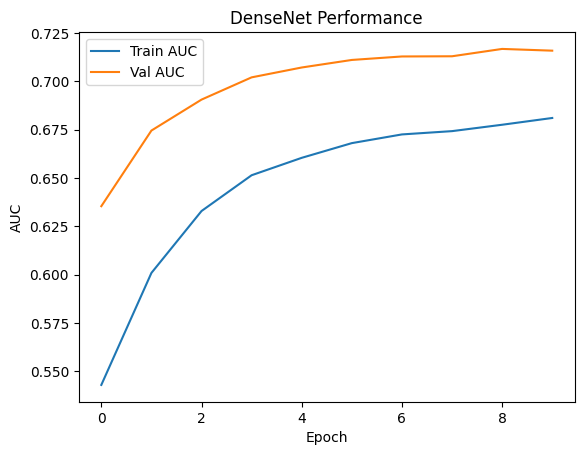

In [3]:
import matplotlib.pyplot as plt

train_auc = [0.5430,0.6009,0.6329,0.6514,0.6604,0.6680,0.6725,0.6742,0.6775,0.6810]
val_auc   = [0.6354,0.6745,0.6905,0.7020,0.7071,0.7110,0.7128,0.7129,0.7167,0.7158]

plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Val AUC')
plt.title('DenseNet Performance')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.models import load_model

densenet_model = load_model("/Users/anshikalohan/Downloads/densenet_model.keras")

In [12]:
densenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,080,556 (27.01 MB)

 Trainable params: 14,350 (56.05 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 28,702 (112.12 KB)

In [32]:
test_loss, test_auc = densenet_model.evaluate(valid_gen)
print("Test Loss:", test_loss)
print("Test AUC:", test_auc)

701/701 ━━━━━━━━━━━━━━━━━━━━ 2424s 3s/step - auc: 0.7160 - loss: 0.2138
Test Loss: 0.2138478010892868
Test AUC: 0.7160351872444153


In [34]:
y_pred = densenet_model.predict(valid_gen)
y_pred_binary = (y_pred > 0.5).astype(int)

701/701 ━━━━━━━━━━━━━━━━━━━━ 2395s 3s/step


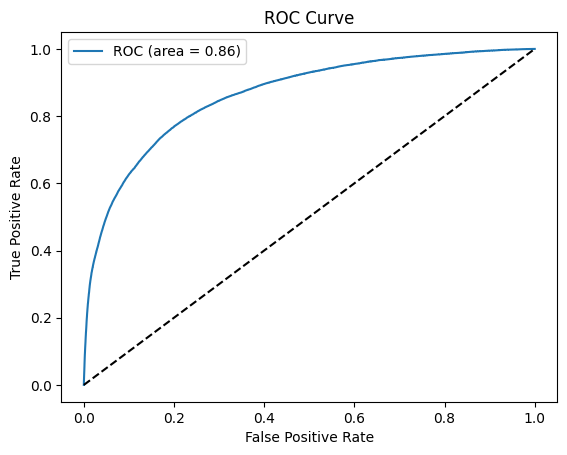

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(valid_gen.labels.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="ROC (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

701/701 ━━━━━━━━━━━━━━━━━━━━ 2556s 4s/step


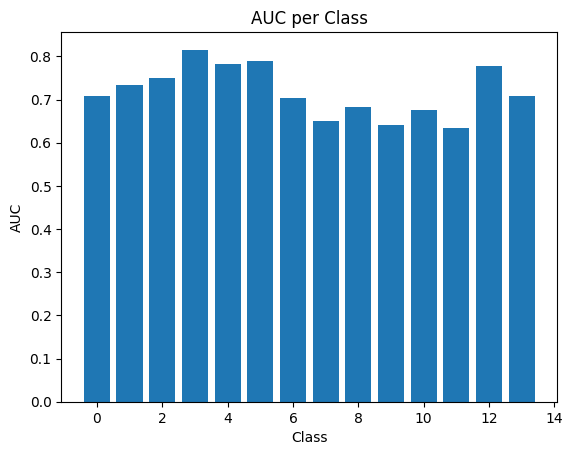

In [44]:
y_pred = densenet_model.predict(valid_gen)
y_true = valid_gen.labels

from sklearn.metrics import roc_auc_score

auc_scores = roc_auc_score(y_true, y_pred, average=None)

plt.bar(range(len(auc_scores)), auc_scores)
plt.title("AUC per Class")
plt.xlabel("Class")
plt.ylabel("AUC")
plt.show()

In [47]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = multilabel_confusion_matrix(y_true, y_pred_binary)